In [1]:
# check GPU
!nvidia-smi

Tue Jan 10 20:48:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# pulls repo to colab
!git clone https://github.com/char-tan/mode_connectivity.git

# checkout specific branch if needed
!cd mode_connectivity; git checkout geodesics

Cloning into 'mode_connectivity'...
remote: Enumerating objects: 651, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 651 (delta 132), reused 156 (delta 83), pack-reused 385
Receiving objects: 100% (651/651), 27.25 MiB | 15.80 MiB/s, done.
Resolving deltas: 100% (376/376), done.
Branch 'geodesics' set up to track remote branch 'geodesics' from 'origin'.
Switched to a new branch 'geodesics'


In [4]:
# allows you to change the .py files and have the imports updated
%load_ext autoreload
%autoreload 2

In [5]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

sys.path.append("mode_connectivity")

In [1]:
import torch
from torchvision import transforms, datasets
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from mode_connectivity.utils import weight_matching, data, training_utils, plot, utils
from mode_connectivity.training_config import *
from mode_connectivity.lmc import *
from mode_connectivity.training import *

from mode_connectivity.models.mlp import MLP

from google.colab import files

ModuleNotFoundError: No module named 'mode_connectivity'

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
import torch


In [4]:
weight_list = torch.load('opt_weights_mlpab_fullmnist_maxiter1k_lr02.pt', map_location=torch.device('cpu') )

In [6]:
weight_list[1]

OrderedDict([('layer0.weight',
              tensor([[ 0.0098, -0.0156,  0.0117,  ...,  0.0253, -0.0283,  0.0261],
                      [-0.0060, -0.0343, -0.0156,  ...,  0.0101, -0.0202, -0.0263],
                      [-0.0154, -0.0188, -0.0179,  ..., -0.0048, -0.0192,  0.0051],
                      ...,
                      [ 0.0145,  0.0210,  0.0115,  ..., -0.0126,  0.0098,  0.0223],
                      [-0.0077, -0.0125,  0.0246,  ..., -0.0111, -0.0141,  0.0077],
                      [ 0.0198,  0.0358, -0.0008,  ..., -0.0290, -0.0247, -0.0065]])),
             ('layer0.bias',
              tensor([-2.1022e-02, -4.1399e-03,  3.3752e-02, -1.4447e-02, -1.4079e-02,
                      -1.3493e-02,  3.0762e-02, -1.9259e-02,  3.6823e-03,  1.8062e-02,
                      -1.8521e-03, -1.0846e-02, -1.8244e-02, -3.6529e-02, -6.4898e-03,
                      -5.2925e-03,  2.5614e-02, -1.1581e-02,  2.2418e-02,  1.2337e-03,
                      -1.5169e-02,  1.5295e-02, -2.0254e-0

# Training MLP models

In [12]:
# class for adding noise to data
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [13]:
training_config = MLP_MNIST_DEFAULT
training_config.epochs = 5
training_config.seed = 7

# train model a
model_a_noisy = train_model(*setup_train(training_config, additional_train_transforms = [AddGaussianNoise(0., 0.1)]), verbose = 1)
torch.save(model_a_noisy.state_dict(), 'model_a_noisy_0.1.pt')

# change seed to get different model
training_config.seed = 42

# train model b
model_b_noisy = train_model(*setup_train(training_config, additional_train_transforms = [AddGaussianNoise(0., 0.1)]), verbose = 1)
torch.save(model_b_noisy.state_dict(), 'model_b_noisy_0.1.pt')  

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

In [ ]:
files.download('model_a_noisy_0.1.pt')
files.download('model_b_noisy_0.1.pt')

# LMC in param space

In [9]:
n_points = 20
(
    permuted_params,
    train_acc_naive,
    test_acc_naive,
    train_acc_perm,
    test_acc_perm,
) = linear_mode_connect(
    MLP, "model_a_noisy_0.1.pt", "model_b_noisy_0.1.pt", "mnist", n_points=n_points, verbose=1
)
torch.save(permuted_params, 'model_pb_noisy_0.1.pt') 
files.download('model_pb_noisy_0.1.pt') 


performing naive interpolation
point 20/20. 
permuting model

performing permuted interpolation


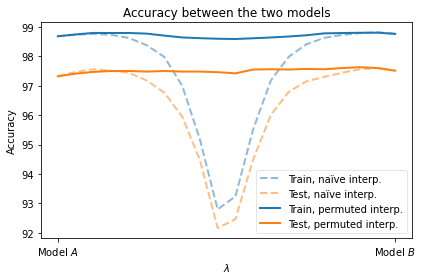

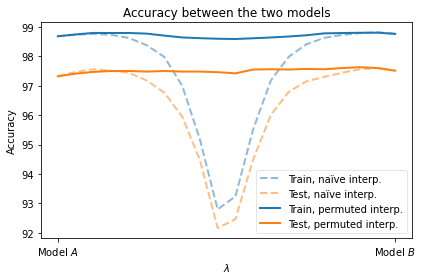

In [13]:
# First we do the basic linear interpolation plot
lambdas = torch.linspace(0, 1, steps=n_points)
plot.plot_interp_metric("accuracy", lambdas, train_acc_naive, test_acc_naive, train_acc_perm, test_acc_perm)

# Geodesic MC in functional space

In [8]:
from mode_connectivity.geodesic_opt import optimise_for_geodesic, metric_path_length
from mode_connectivity.utils import metrics

In [10]:
device, device_kwargs = get_device()

In [11]:
print(device, device_kwargs)

cuda {'num_workers': 1, 'pin_memory': True}


In [12]:
trainset = datasets.MNIST(
    root="./data", train=True, download=True,
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

testset = datasets.MNIST(
    root="./data", train=False, download=True,
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [13]:
from torch.utils.data import DataLoader, ConcatDataset

mnist_dataset = ConcatDataset([trainset, testset])

all_mnist_dl = DataLoader(dataset = mnist_dataset, batch_size=mnist_dataset.__len__())

all_mnist_images, all_mnist_lables = next(iter(all_mnist_dl))

In [24]:
all_mnist_images = all_mnist_images.to(device)

print(all_mnist_images.shape,all_mnist_images.device)

torch.Size([70000, 1, 28, 28]) cuda:0


In [25]:
# load in model state_dicts
model_file_path = 'mode_connectivity/model_files/'

weights_a = torch.load(model_file_path + "mlp_model_a_noisy_0.1.pt", map_location=device)
weights_b = torch.load(model_file_path + "mlp_model_b_noisy_0.1.pt", map_location=device)
weights_pb = torch.load(model_file_path + "mlp_model_pb_noisy_0.1.pt", map_location=device)

In [26]:
print(all_mnist_images[0:100].get_device())

0


In [ ]:
n_points = 20
opt_weights, losses = optimise_for_geodesic(
        MLP, weights_a, weights_b,
        n = n_points,
        loss_metric = metrics.JSD_loss,
        data = all_mnist_images[0:512],
        max_iterations = 1000,
        learning_rate = .3
    )

plt.plot(losses)

In [41]:
torch.save(opt_weights, 'opt_weights.pt')
files.download('opt_weights.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
torch.save(losses, 'losses.pt')
files.download('losses.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>